<a href="https://colab.research.google.com/github/cat2304/GameTheoryAI/blob/new-main/train_rfdetr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
from google.colab import userdata

os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")
os.environ["ROBOFLOW_API_KEY"] = userdata.get("ROBOFLOW_API_KEY")
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [ ]:
!nvidia-smi

In [ ]:
!pip install -q rfdetr==1.1.0

In [ ]:
from roboflow import download_dataset
dataset = download_dataset("https://universe.roboflow.com/ai-qrccw/my-first-project-i9qhe/dataset/25", "coco")

In [ ]:
from rfdetr import RFDETRBase

model = RFDETRBase(
    encoder="dinov2_windowed_small",
    resolution=560,
    hidden_dim=256,
    dec_layers=3,
    drop_path_rate=0.1,
    num_classes=53,             # ✅ 必须明确设置为你的类别数（53）
    force_no_pretrain=False
)

model.train(
    dataset_dir=dataset.location,
    epochs=100,
    batch_size=2,
    grad_accum_steps=8,
    lr=1e-4,
    amp=True,
    use_ema=True,
    checkpoint_interval=5,
    tensorboard=True,
    lr_drop=10,
    warmup_epochs=1,
    early_stopping=True,
    early_stopping_patience=15,
    resume=True
)

model.export(format="onnx")

In [ ]:
from rfdetr import RFDETRBase

model = RFDETRBase(
    encoder="dinov2_windowed_small",
    resolution=560,
    hidden_dim=256,
    dec_layers=4,
    drop_path_rate=0.1,
    force_no_pretrain=False,
    num_classes=53                # ✅ 指定你训练时使用的扑克牌类别数
)

model.export(
    resume="/content/rf-detr-base.pth",
    format="onnx",
    path="output/inference_model.onnx"
)

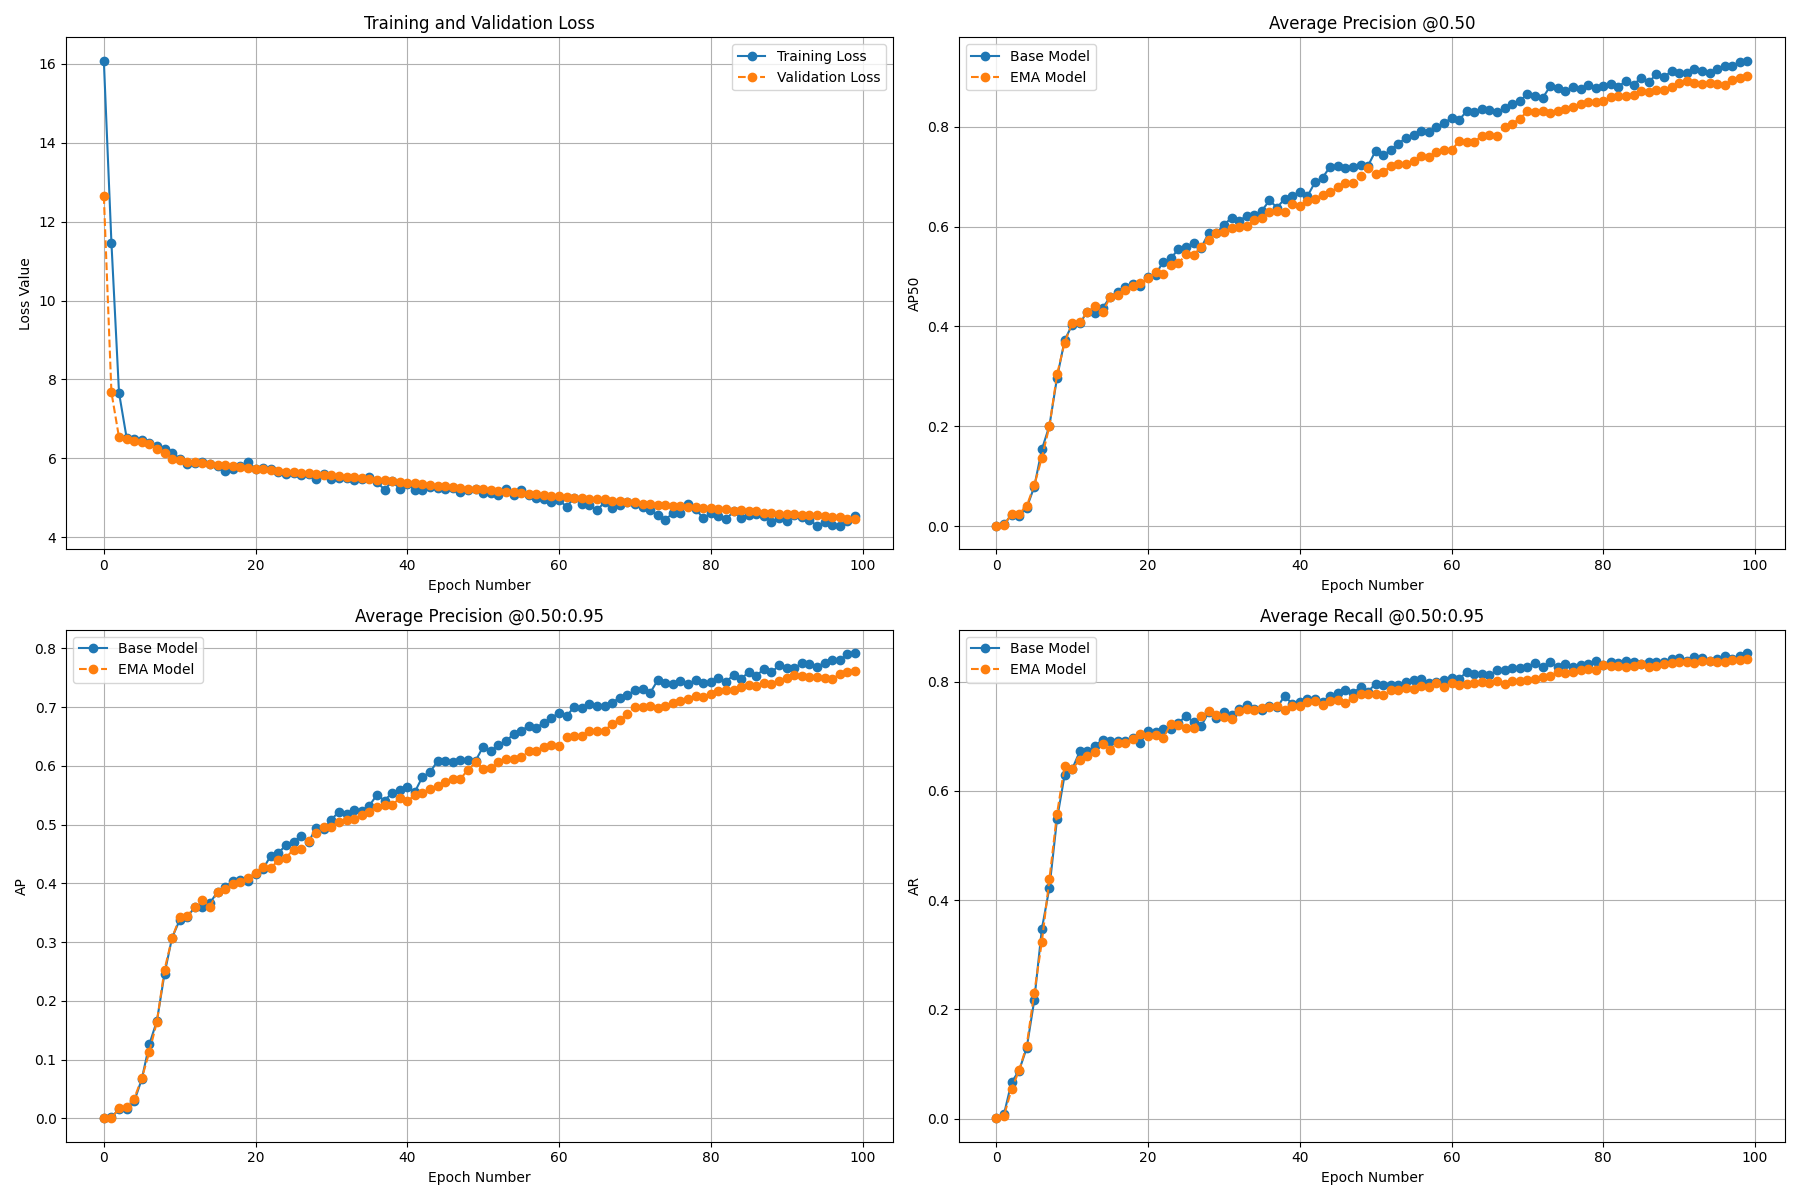

In [11]:
from PIL import Image

Image.open("/content/output/metrics_plot.png")

## Run inference with fine-tuned model

In [12]:
import supervision as sv

ds = sv.DetectionDataset.from_coco(
    images_directory_path=f"{dataset.location}/test",
    annotations_path=f"{dataset.location}/test/_annotations.coco.json",
)

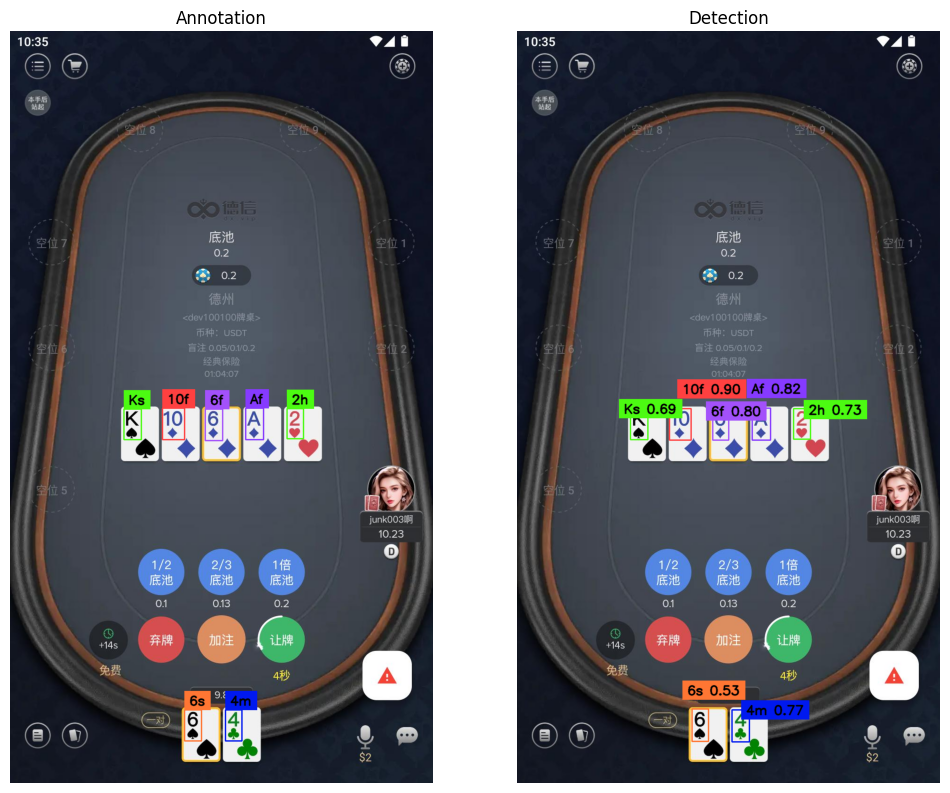

In [13]:
from rfdetr import RFDETRBase
import supervision as sv
from PIL import Image

path, image, annotations = ds[0]
image = Image.open(path)

detections = model.predict(image, threshold=0.5)

text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

bbox_annotator = sv.BoxAnnotator(thickness=thickness)
label_annotator = sv.LabelAnnotator(
    text_color=sv.Color.BLACK,
    text_scale=text_scale,
    text_thickness=thickness,
    smart_position=True)

annotations_labels = [
    f"{ds.classes[class_id]}"
    for class_id
    in annotations.class_id
]

detections_labels = [
    f"{ds.classes[class_id]} {confidence:.2f}"
    for class_id, confidence
    in zip(detections.class_id, detections.confidence)
]

annotation_image = image.copy()
annotation_image = bbox_annotator.annotate(annotation_image, annotations)
annotation_image = label_annotator.annotate(annotation_image, annotations, annotations_labels)

detections_image = image.copy()
detections_image = bbox_annotator.annotate(detections_image, detections)
detections_image = label_annotator.annotate(detections_image, detections, detections_labels)

sv.plot_images_grid(images=[annotation_image, detections_image], grid_size=(1, 2), titles=["Annotation", "Detection"])

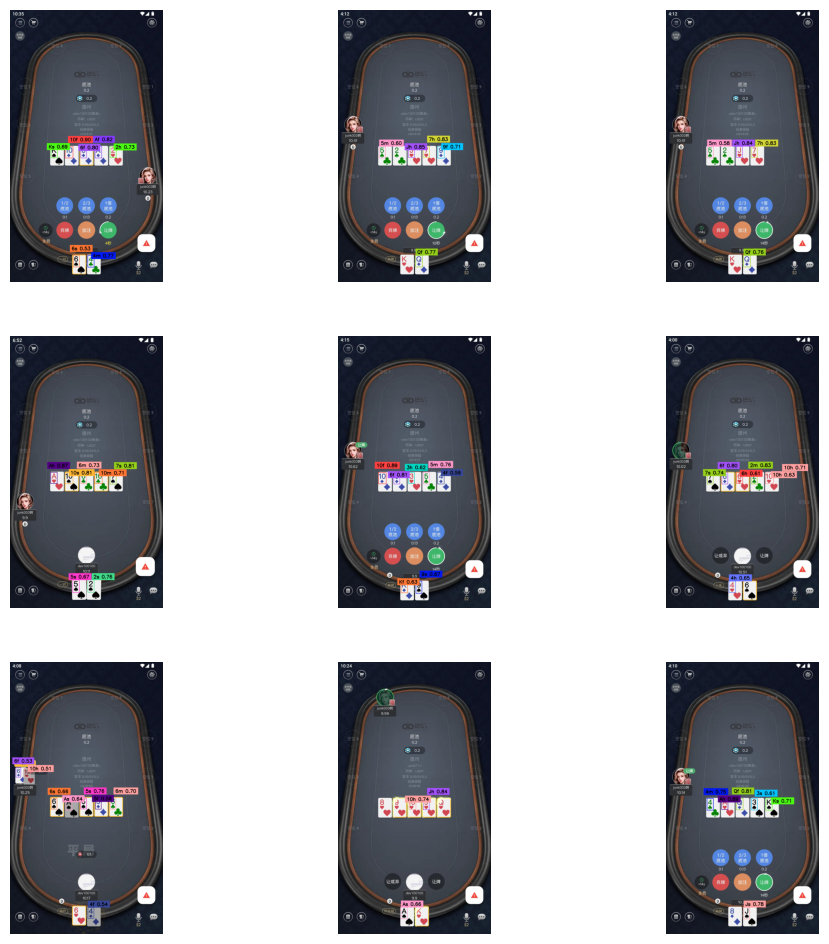

In [14]:
import supervision as sv
from rfdetr import RFDETRBase
from PIL import Image

detections_images = []

for i in range(9):
    path, image, annotations = ds[i]
    image = Image.open(path)

    detections = model.predict(image, threshold=0.5)

    text_scale = sv.calculate_optimal_text_scale(resolution_wh=image.size)
    thickness = sv.calculate_optimal_line_thickness(resolution_wh=image.size)

    bbox_annotator = sv.BoxAnnotator(thickness=thickness)
    label_annotator = sv.LabelAnnotator(
        text_color=sv.Color.BLACK,
        text_scale=text_scale,
        text_thickness=thickness,
        smart_position=True)

    detections_labels = [
        f"{ds.classes[class_id]} {confidence:.2f}"
        for class_id, confidence
        in zip(detections.class_id, detections.confidence)
    ]

    detections_image = image.copy()
    detections_image = bbox_annotator.annotate(detections_image, detections)
    detections_image = label_annotator.annotate(detections_image, detections, detections_labels)

    detections_images.append(detections_image)

sv.plot_images_grid(images=detections_images, grid_size=(3, 3), size=(12, 12))

[链接文字](https://)## Evaluate fine-tuned model

In [15]:
import supervision as sv
from tqdm import tqdm
from supervision.metrics import MeanAveragePrecision

targets = []
predictions = []

for path, image, annotations in tqdm(ds):
    image = Image.open(path)
    detections = model.predict(image, threshold=0.5)

    targets.append(annotations)
    predictions.append(detections)

100%|██████████| 29/29 [00:01<00:00, 16.58it/s]


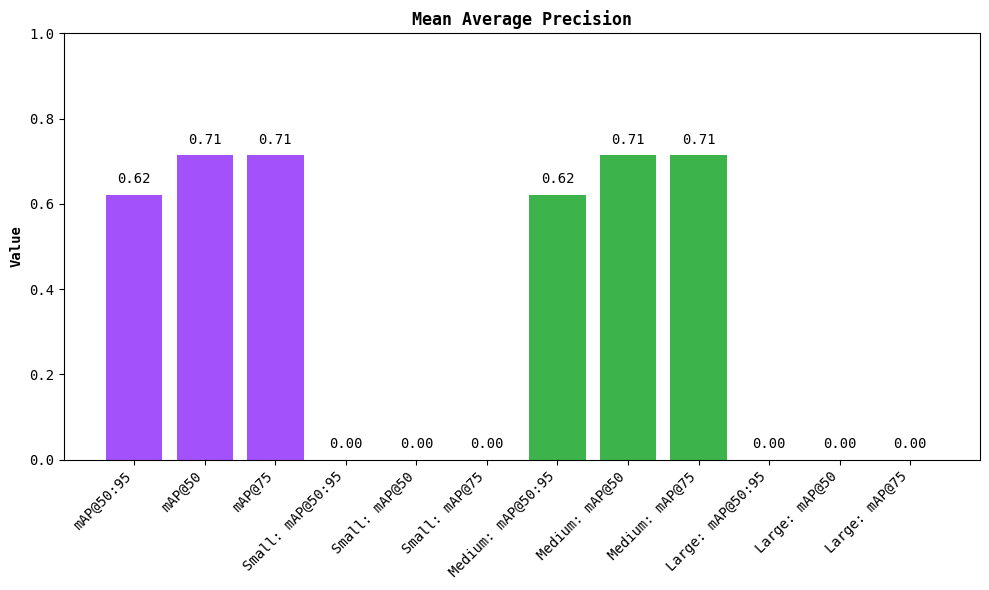

In [16]:
map_metric = MeanAveragePrecision()
map_result = map_metric.update(predictions, targets).compute()

map_result.plot()

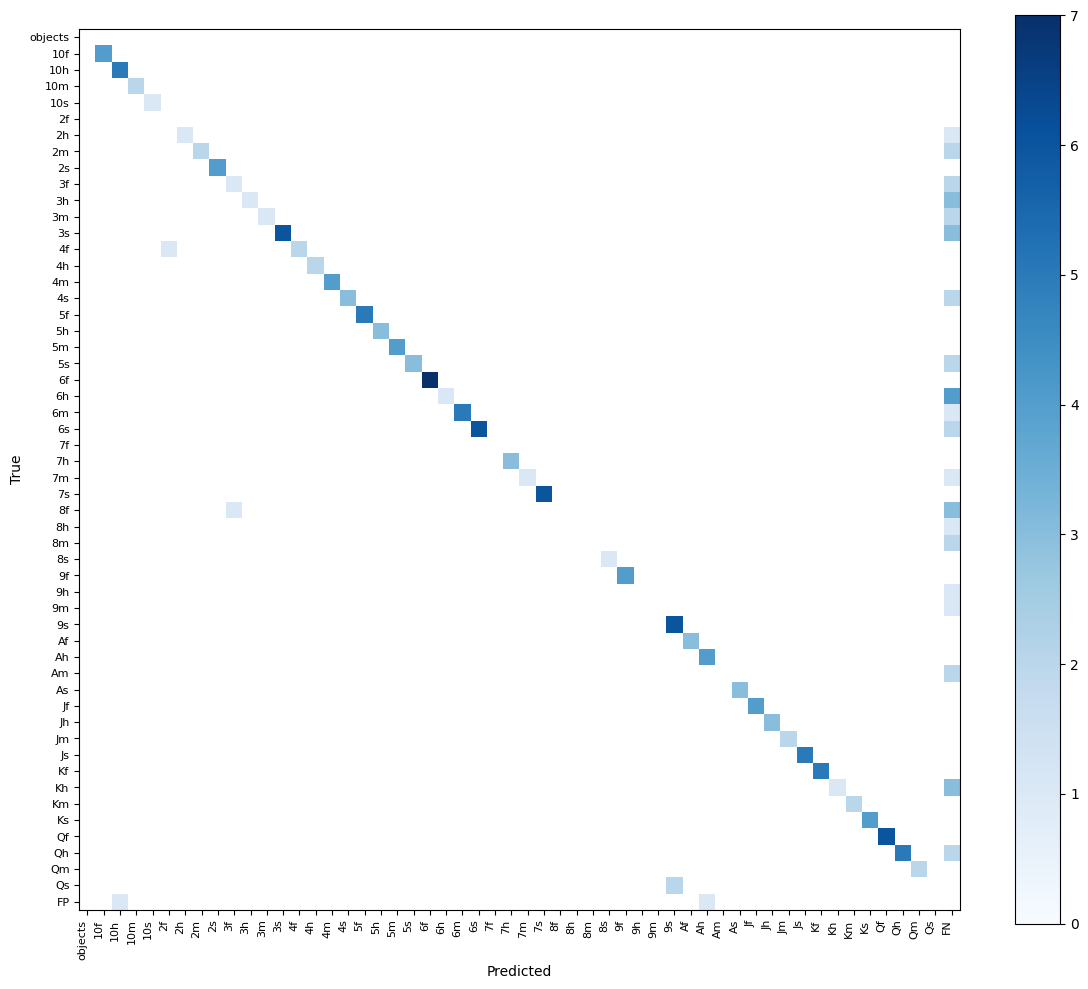

In [17]:
confusion_matrix = sv.ConfusionMatrix.from_detections(
    predictions=predictions,
    targets=targets,
    classes=ds.classes
)

confusion_matrix.plot()